## Convolution

We know from our linear time-invariant (LTI) systems theory that if we know the impulse response of an LTI system, then we can obtain the output of that system for any input by convolving the input with the impulse response (IR) of the LTI system. In this notebook, we'll attempt to get a better understanding of what a convolution operation is actually doing by visualizing this operation. 

A much more fun version of this notebook can be found [here](https://github.com/randyaliased/acs-sp-demos/blob/main/04_Impulse%20Response%20and%20Convolution.ipynb), where we firstly do a crude impulse response measurement in class by popping a balloon. As we can't directly record audio in these online notebooks, I'll alternatively import an impulse response from the [MYRiAD database](https://zenodo.org/records/7389996) as the starting point.

In [ ]:
# Import the necessary packages as usual
%pip install ipympl
import numpy as np 
import scipy as sp
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
speech_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/F2.wav"
impulse_resp = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/IR1.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

### The signals to be convolved

Let's take a room as an example of an LTI system. We can imagine an input signal as someone speaking in one location of the room and the output signal to be the resulting sound at any point within the room. In between the input and output, we essentially have the room itself which acts as a system. Hence the voice will be modified or filtered by the room before it arrives to any point within the room. It is the acoustic properties of the room (such as how absorptive/reflective materials are in the room) that determine the impulse response of the room system. Think about how other rooms affect any input sound - a cave, a concert hall, etc. All of these systems can be quantitatively described by their acoustic impulse responses, which is in fact one of the most important pieces of information for doing audio signal processing in general. 

So let's import two signals: (i) the input speech signal, denoted by $x[n]$, and (ii) a measured impulse response between two positions within an actual room, which we denote as $h[n]$. For more details on the dataset from which this impulse response was retrieved and how it was measured, you can take a look at {cite:p}`dietzen2023myriad`. 

The speech input signal, x[n]:


The impulse response signal, h[n]:


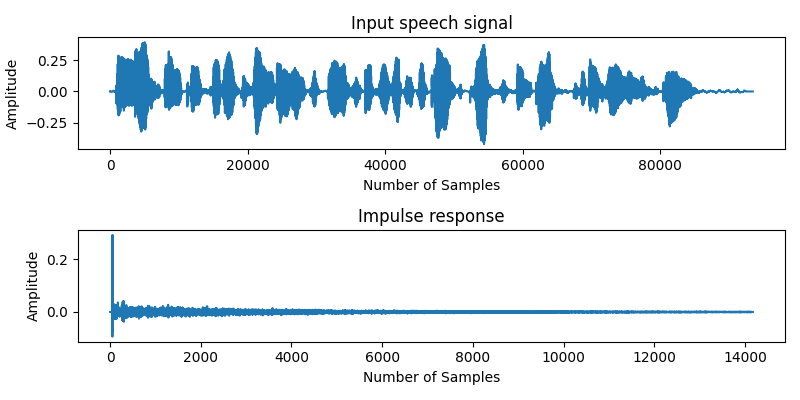

In [ ]:
# Read in the speech signal
speech, fs = await read_wav_from_url(speech_sample) 
print('The speech input signal, x[n]:')
IPython.display.display(Audio(speech.T, rate=fs))

# Read in the IR signal
h, fs = await read_wav_from_url(impulse_resp)
print('The impulse response signal, h[n]:')
IPython.display.display(Audio(h.T, rate=fs))

# Plot the signals
fig, axes = plt.subplots(2,1, figsize=(6, 4)) 
axes[0].plot(speech)
axes[0].set_title('Input speech signal')
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot(h)
axes[1].set_title('Impulse response')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Amplitude')
plt.show()
plt.tight_layout()

### Convolution

Okay so now we are ready for the convolution. Recall the discrete-time convolution is given by the following equation:

$\begin{equation}
y[n] = \sum_{k} h[n-k] x[k]
\end{equation}$

where $y[n]$ is the convolved signal, and we recall that $h[n]$ is the impulse response, and $x[n]$ is the input signal. In general for an input $x[n]$ of length, $L$ samples, and an impulse response of length $M$ samples, then the total length of the output after the convolution will be $L+M-1$ samples. One way we can think of this convolution operation by firstly flipping the impulse response around $n=0$. For each value of $n$, we then shift this flipped impulse response by $n$, where it will begin to overlap with $x[k]$. We multiply the two signals and sum the result to get the value at y[n]. This is much easier to visualise, so let's do that instead! Because of the sort of brute force way we are doing this to visualize it, the following snippet of code may take about 10-20 seconds to run (at least on my machine).

In [1]:
# We can simply use some built-in python functions to compute the convolution using the input and IR 
# as we already have it. But to visualise the process, we will need to do some zero padding to the signals
# The total length of the convolution = L + M - 1, where L is the length of the input and M is the length of the
# impulse response.

M = len(h)
L = len(speech)
print('Length of impulse response, M = ' + str(M)+ ' samples')
print('Length of input speech signal, L = ' +str(L)+ ' samples')
print('Length of convolution = '+str(M+L-1)+ ' samples')

x_zp = np.zeros(M+L-1) # input zero padded
h_zp = np.zeros(M+L-1) # IR zero padded
y = np.zeros(M+L-1) # output

x_zp[M-1:] = speech
h_zp[0:M] = np.flip(h)
sample_idx = np.arange(0,M+L-1,1)

#Pre-compute the convolution
for n in sample_idx:
    h_shift = np.roll(h_zp,n)
    h_shift[0:n] = 0
    y[n] = x_zp@h_shift  # compute inner product 
        

fig, axes = plt.subplots(2,1,figsize=(8, 4)) 
fig.subplots_adjust(hspace=0.7)
axes[0].plot(x_zp, label = 'x')
line, = axes[0].plot(h_zp,alpha=0.4,label='h')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([0, M+L-1])
axes[0].legend()


line2, = axes[1].plot([],[],'g-')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Convolution Result, y = h * n')
axes[1].set_xlim([0, M+L-1])
axes[1].set_ylim([np.min(y), np.max(y)])



def update(n = 0):
    fig.canvas.draw_idle()
    h_shifted = np.roll(h_zp,n)
    h_shifted[0:n] = 0
    line.set_ydata(h_shifted)
    axes[0].set_title('n = ' + str(n))
    
    line2.set_data(sample_idx[0:n+1], y[0:n+1])

print('Move the slider to see the convolution in action.')
print('The value n corresponds to the shift in the summation of the discrete-time convolution formula')
interact(update, n = (0,L+M-1,1));


print('Listen to the output convolved signal, y[n]!')
IPython.display.display(Audio(y.T, rate=fs))



NameError: name 'h' is not defined

### Commutativity

Instead of flipping the impulse response and shifting it, we could have alternatively flipped the input signal and shifted it through the impulse response. The reason we can do this is because of the commutative property the holds for the convolution:

$\begin{equation}
y[n] = \sum_{k} h[n-k] x[k] = \sum_{k} x[n-k] h[k] 
\end{equation}$

This is a really useful property and is worth remembering when interpreting how signals interact with each other.


### Matrix-vector product

As opposed to doing the convolution by directly implementing the discrete-time convolution equation, we can also organise the samples of the impulse response into a convolution matrix (which has a toeplitz structure) and do a matrix-vector product with the input signal: 

\begin{equation}
\mathbf{y} = \mathbf{H}\mathbf{x}
\end{equation}

where $\mathbf{y}$ is the vector of output samples, $\mathbf{H}$ is the convolution matrix, and $\mathbf{x}$ is the vector of input samples. To see this explicitly, consider a simple example where the length of the IR, M = 3 and length of the input signal, L = 4:

$\begin{equation}
\begin{bmatrix} y[0] \\ y[1] \\ y[2] \\ y[3] \\ y[4] \\ y[5] \end{bmatrix} = \begin{bmatrix} h[0] & 0 & 0 & 0 \\ h[1] & h[0] & 0 & 0 \\ h[2] & h[1] & h[0] & 0 \\ 0 & h[2] & h[1] & h[0] \\ 0 & 0 & h[2] & h[1] \\ 0 & 0 & 0 & h[2] \end{bmatrix} \begin{bmatrix} x[0] \\ x[1] \\ x[2] \\ x[3] \end{bmatrix} 
\end{equation}$

We can think of this matrix-vector product in two ways:

1. Inner products of each row of $\mathbf{H}$ with the input, $\mathbf{x}$. This in fact corresponds to the picture we previously illustrated, where the impulse response is flipped and continuously shifted over the input signal.

$\begin{equation}
\begin{bmatrix} y[0] \\ y[1] \\ y[2] \\ y[3] \\ y[4] \\ y[5] \end{bmatrix} = \begin{bmatrix} h[0] & 0 & 0 & 0  \end{bmatrix} \begin{bmatrix} x[0] \\ x[1] \\ x[2] \\ x[3] \end{bmatrix}  + \begin{bmatrix} h[1] & h[0] & 0 & 0 \end{bmatrix} \begin{bmatrix} x[0] \\ x[1] \\ x[2] \\ x[3] \end{bmatrix}  + \dots +  \begin{bmatrix} 0 & 0 & 0 & h[2] \end{bmatrix} \begin{bmatrix} x[0] \\ x[1] \\ x[2] \\ x[3] \end{bmatrix} 
\end{equation}$



2. Linear combinations of the columns of $\mathbf{H}$. Each column of $\mathbf{H}$ corresponds to a shifted version of the impulse response. Hence we can think of the convolution as weighted combinations of shifted versions of the impulse response, where the weights are given by the values of the input samples.

$\begin{equation}
\begin{bmatrix} y[0] \\ y[1] \\ y[2] \\ y[3] \\ y[4] \\ y[5] \end{bmatrix} = x[0] \begin{bmatrix} h[0]  \\ h[1]  \\ h[2]  \\ 0  \\ 0 \\ 0  \end{bmatrix}  + x[1] \begin{bmatrix} 0 \\ h[0]  \\ h[1]  \\ h[2]  \\ 0  \\ 0  \end{bmatrix} + \dots + x[3] \begin{bmatrix} 0\\ 0\\ 0\\ h[0]  \\ h[1]  \\ h[2]  \end{bmatrix} 
\end{equation}$

You can already see that this is pretty slow and inefficient as the matrix, $\mathbf{H}$ can get very large, however it does give us some more insight into what we are doing when we perform a convolution. I will not attempt to do this here (it was too heavy for my machine), but if you are curious, you can use the [toeplitz](https://docs.scipy.org/doc/scipy-1.16.1/reference/generated/scipy.linalg.toeplitz.html) function in Python. 

### The impulse response and room acoustic modelling

<video controls style="max-width:100%; height:auto;">
  <source src="../animations/room_IR_model.mp4" type="video/mp4">
</video>
